# #Masks Throughout COVID-19: A Twitter Sentiment Analysis

## Natural Language Processing and Data Exploration

## Table of contents
1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Answering the initial questions](#Step-1:-Answering-the-initial-questions)
5. [Step 2: Preparing the data](#Step-2:-Preparing-the-data)

    - [Obtain target variable](#Obtain-target-variable)
    
    
6. [Step 3: Natural language processing and feature engineering](#Step-3:-Natural-language-processing-and-feature-engineering)

    - [Sparse word vector matrix](#Sparse-word-vector-matrix)
    - [LDA topic modeling](#LDA-topic-modeling)
    - [Subjectivity scores](#Subjectivity-scores)
    
    
7. [Step 4: Exploratory data analysis](#Step-4:-Exploratory-data-analysis)

    - [Sentiment over time](#Sentiment-over-time)
    - [Twitter statistics](#Twitter-statistics)
    - [Top words and vocabulary statistics](#Top-words-and-vocabulary-statistics)
    - [LDA topics](#LDA-topics)
    - [Subjectivity](#Subjectivity)
    

8. [Next notebook: Modeling](#Next-notebook:-Modeling)

## Introduction

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

After scraping Twitter with [Twint](https://github.com/twintproject/twint), [Eric Blander](https://github.com/EricB10) and [I](https://github.com/p-szymo) will use natural language processing (NLP) techniques to analyze the sentiment of tweets relating to masks and coronavirus.

Through text processing, exploratory data analysis and feature engineering, we will look for insights into how important words, topics, and subjectivity relate to sentiment.

We will then create predictive models that classify tweets as *negative*, *neutral*, or *positive*. This will help us provide further insight and confirm our findings during EDA. *(NOTE: To skip to the modeling notebook, click [here](04_modeling.ipynb))*.

## The problem domain

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

Within the U.S., the official narrative on masks within the early days of the pandemic was surprising, in that government bodies were claiming that masks were [ineffective](https://twitter.com/surgeon_general/status/1233725785283932160?lang=en) in stopping the spread. Eventually, there was a stark shift in this narrative toward the necessity of wearing masks to "[protect each other](https://twitter.com/surgeon_general/status/1264166726230573057?lang=en)". The difference in tweets about masks by the Surgeon General in February (which were overwhelmingly negative) and his tweets in May (overwhelmingly positive) paint an important yet unfortunate picture of how officials dropped the ball in the pandemic's early days.

We began to wonder whether there was a similar shift within the country as a whole. How has the country's attitude toward masks changed since the early days of COVID-19, or has it remained relatively constant? We decided to look to Twitter to investigate if we could develop a clearer picture of the country's mood during these crucial and trying months.

## Required libraries

[[go back to the top](#Verifying-Volunteer-Entries-to-the-NYC-Trees-Census)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

- **numpy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **scikit-learn**: The essential Machine Learning package in Python.
- **scipy**: The essential statistical analysis package in Python.
- **statsmodels**: Another stastical analysis package.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **seaborn**: Advanced statistical plotting library.
- **collections**: A package with specialized and higher-performance data structures.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages that you may have to install:

- **nltk**: The essential natural language processing package.
- **gensim**: A more specialized natural language processing package.
- **textblob**: A supplementary package to enhance the nltk package.
- **vaderSentiment**: A sentiment analysis tool based on human-compiled data.
- **wordcloud**: A library focused on plotting word frequencies.
- **pickle**: Package to save a file as a byte stream.
- **gzip**: Package to compress/unpack files.

Finally, included within the repository, and necessary to run this workbook, is:
- **[functions](functions.py)**: Custom functions that we built for this project.

Run the cell below to import all of the necessary packages.

In [1]:
# standard packages
import numpy as np
import pandas as pd

# visualization packages
import matplotlib
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# text processing/nlp packages
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats
from scipy.sparse import csr_matrix
import statsmodels.api as sm 
from collections import Counter

# saving/loading packages
import gzip
import pickle

# custom functions and reload after editing
from functions import *
%load_ext autoreload
%autoreload 2

# ignore sklearn warnings
# (code from: https://stackoverflow.com/questions/32612180/eliminating-warnings-from-scikit-learn)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# increase column width to more easily read tweets
pd.set_option('max_colwidth', 150)

# Step 1: Answering some initial questions
[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

**Where does the data come from?**

> The data is comprised of 575,949 tweets and tweet characteristics from January 1 to May 31. They were scraped from Twitter using [Twint](https://github.com/twintproject/twint).

> Refer to the Twitter scraping [notebook](01_twitter_scraping.ipynb) for a closer look at the scraping process.

> Refer to the data cleaning [notebook](02_data_cleaning.ipynb) for a detailed guide on the cleaning process.

**What do the variables mean in actual language?**

> The tweet itself is the main variable; a tweet is the original text including mentions (references to other Twitter users), hashtags (a way to denote and link to a topic on Twitter), and emojis/emoticons (pictographic representations of tone/feeling/emotion). We will process each tweet to filter it down to only the most important words (including hashtags and emoji "translations").

> Other variables that we scraped and explored include date, nlikes (number of likes a tweet received), nreplies (number of replies to the tweet), nretweets (number of times the tweet was shared by other users).

**What is the target variable?**

> The target variable is the sentiment of the tweet--*positive*, *negative*, or *neutral*. We used [VADER](https://github.com/cjhutto/vaderSentiment) to obtain these labels.
    
**What is the range, scale, or distribution of each variable?**

> The vast majority of tweets have 0 likes, replies, or retweets, meaning all are very negatively skewed. It may make more sense to turn these in to categorical variables.
    
**What elements of the data will or will not address the business question?**

> We will drop several columns early on, including ID tags, hashtag lists (the hashtags are included within the tweet text itself), whether or not the tweet is a retweet (we are looking only at original tweets), and any reply documentation.

> We will be keeping usernames as a means of searching for specific users if necessary (i.e., the WHO or Surgeon General), though this variable will not be used in the modeling or exploration.
    
**Are there any issues related to data permissions, copyright, ethical issues, confidential information, etc.?**

> Technically, one is supposed to use Twitter's API to scrape tweets, but there are several key limitations on this (including limiting returned tweets to around 3,200) that made this unusable for this project. Twint solves this by utilizing Twitter's search operators and manually retrieving tweets in a relatively quick fashion. While I will admit ignorance as to the legality of using Twint, I don't there are any real ethical or copyright issues here, considering no money is being made off of this project, which I believe is of scientific value.
    
**Are there any interesting aspects or anomalies in the data such as outliers or missing data?**

> *Positive* and *negative* tweets account for a roughly equal share of tweets but there is a notable class imbalance within the target variable when looking at *neutral* tweets. About 42% of tweets are *positive*, 38% are *negative*, and 20% are *neutral*.

> Of the variables mentioned above, there are no missing data. Early on, we will drop certain columns that were unnecessary for this project. The majority of our continuous data appears to be zeros, so it may be worth considering converting these into categorical (likes vs. no likes, replies vs. no replies, retweeted vs. not retweeted).
    
**What additional data would be really helpful to your analysis?**

> The only additional data that would be helpful is being able to use the full number of tweets from this time period. Unfortunately, due to the limitations of our computing power, we've had to limit our tweets to 5000 maximum per day. In the future, we would consider figuring out a way to use all the data available.

**Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?**

> This will be an NLP, exploration, feature engineering, and classification project. To look at the classification portion of the project, refer to the modeling [notebook](04_modeling.ipynb).

**Did you define the metric for success before beginning?**

> To help account for there being a class imbalance, we will use F1 score over accuracy, as the F1 is the most complete measure of false predictions and doesn't overemphasize models that simply predict the majority class.

# Step 2: Preparing the data
[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Import the cleaned data.
- Drop any unnecessary columns.
- Obtain target variable.

In [2]:
# load file
df = pd.read_csv('data/jan_thru_may_5k_tweets_clean.csv', index_col=0)

# convert date column to datetime
df['date'] = df.date.astype('datetime64[ns]')

# check shape
df.shape

(575949, 17)

In [3]:
# look at the first five rows
df.head()

id  conversation_id    created_at       date  \
0  1.212523e+18     1.212523e+18  1.577923e+12 2020-01-01   
1  1.212518e+18     1.212518e+18  1.577922e+12 2020-01-01   
2  1.212518e+18     1.212518e+18  1.577922e+12 2020-01-01   
3  1.212516e+18     1.200523e+18  1.577921e+12 2020-01-01   
4  1.212510e+18     1.212391e+18  1.577920e+12 2020-01-01   

                                                                                                                                                   tweet  \
0                                               https://mltshp.com/p/1HLSB  "This is the death mask of Thomas, an unknown peasant that died in a river."   
1  Ready to heard this? Homemade hair treatment and ann cherry dead sea mud mask... Fucking putas swear they are more woman than me.... Bitch shut th...   
2  We all know what a joke #CCPChina is when it comes to epidemic outbreak,think of how they stayed silent about #SARS.\nDear world,stay away from #H...   
3                                                                                                            Thought death masks gave you the horn freak   
4                               Interesting cult of death mask he’s wearing, 🤔\nelectronically posing as he did as of the CIA while Brennan was Chief. 🧐   

                                  hashtags       user_id        username  \
0                                       []  8.431951e+17  Best_of_MLTSHP   
1                                       []  1.044739e+18       lumora_lu   
2  ['#ccpchina', '#sars', '#hk', '#hkers']  9.630325e+17        odiecher   
3                                       []  2.819219e+09      Hevysmoker   
4                                       []  2.361956e+08        FaithR8s   

                  name  \
0               MLTSHP   
1                 MiLu   
2             odiecher   
3       Ashley Collins   
4  ❌Patriot Fan🇺🇸🗽☕️🎶❌   

                                                            link  retweet  \
0  https://twitter.com/Best_of_MLTSHP/status/1212523477896294400    False   
1       https://twitter.com/lumora_lu/status/1212518043353530368    False   
2        https://twitter.com/odiecher/status/1212517557690748928    False   
3      https://twitter.com/Hevysmoker/status/1212515585562726401    False   
4        https://twitter.com/FaithR8s/status/1212510409858670593    False   

   nlikes  nreplies  nretweets  \
0     1.0       0.0        1.0   
1     0.0       0.0        0.0   
2     1.0       1.0        1.0   
3     0.0       0.0        0.0   
4     1.0       0.0        1.0   

                                                    quote_url  retweet_id  \
0                                                         NaN         NaN   
1                                                         NaN         NaN   
2  https://twitter.com/WBYeats1865/status/1212430526826479616         NaN   
3                                                         NaN         NaN   
4                                                         NaN         NaN   

                                                                                                                                                reply_to  
0                                                                                      [{'user_id': '843195118924546048', 'username': 'Best_of_MLTSHP'}]  
1                                                                                          [{'user_id': '1044738746913034241', 'username': 'lumora_lu'}]  
2                                                                                            [{'user_id': '963032516759207936', 'username': 'odiecher'}]  
3                                 [{'user_id': '2819219369', 'username': 'Hevysmoker'}, {'user_id': '1107018506300780544', 'username': 'cutedeadguys3'}]  
4  [{'user_id': '236195607', 'username': 'FaithR8s'}, {'user_id': '14745988', 'username': 'ThunderB'}, {'user_id': '14138785', 'username': 'Telegraph...

- Drop unnecessary columns.

In [4]:
# drop columns we know we won't need for this project
df.drop(columns=['id', 'conversation_id', 'created_at', 'hashtags', 'user_id', 'name',
                 'retweet', 'quote_url', 'retweet_id', 'reply_to'], inplace=True)

# confirm
df.head()

date  \
0 2020-01-01   
1 2020-01-01   
2 2020-01-01   
3 2020-01-01   
4 2020-01-01   

                                                                                                                                                   tweet  \
0                                               https://mltshp.com/p/1HLSB  "This is the death mask of Thomas, an unknown peasant that died in a river."   
1  Ready to heard this? Homemade hair treatment and ann cherry dead sea mud mask... Fucking putas swear they are more woman than me.... Bitch shut th...   
2  We all know what a joke #CCPChina is when it comes to epidemic outbreak,think of how they stayed silent about #SARS.\nDear world,stay away from #H...   
3                                                                                                            Thought death masks gave you the horn freak   
4                               Interesting cult of death mask he’s wearing, 🤔\nelectronically posing as he did as of the CIA while Brennan was Chief. 🧐   

         username  \
0  Best_of_MLTSHP   
1       lumora_lu   
2        odiecher   
3      Hevysmoker   
4        FaithR8s   

                                                            link  nlikes  \
0  https://twitter.com/Best_of_MLTSHP/status/1212523477896294400     1.0   
1       https://twitter.com/lumora_lu/status/1212518043353530368     0.0   
2        https://twitter.com/odiecher/status/1212517557690748928     1.0   
3      https://twitter.com/Hevysmoker/status/1212515585562726401     0.0   
4        https://twitter.com/FaithR8s/status/1212510409858670593     1.0   

   nreplies  nretweets  
0       0.0        1.0  
1       0.0        0.0  
2       1.0        1.0  
3       0.0        0.0  
4       0.0        1.0

## Obtain target variable

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Use VADER to obtain sentiment scores.
    - ⏰ NOTE: Next cell may take a few minutes to run.
- Convert to target classes using typical thresholds found [here](https://github.com/cjhutto/vaderSentiment).

In [5]:
%%time

# instantiate vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# create a column with the compound polarity score
df['sentiment_score'] = df['tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

CPU times: user 1min 54s, sys: 290 ms, total: 1min 55s
Wall time: 1min 55s


In [6]:
# turn this into our target classes: negative, positive, and neutral
conditions = [
    df.sentiment_score >= .05,
    df.sentiment_score <= -.05
]

choices = [
    'positive',
    'negative'
]

df['sentiment'] = np.select(conditions, choices, 'neutral')

- Take a look at the distribution of our target variable.

In [7]:
df.sentiment.value_counts()

positive    239222
negative    221377
neutral     115350
Name: sentiment, dtype: int64

In [8]:
df.sentiment.value_counts(normalize=True)

positive    0.415353
negative    0.384369
neutral     0.200278
Name: sentiment, dtype: float64

- *Positive* and *negative* tweets are roughly equal in number, though *positive* has an ~18,000 tweet edge.
- *Neutral* tweets are less frequent, occurring roughly half as frequently as either a *positive* or *negative* tweet.


- Drop no longer necessary ```sentiment_score``` column.

In [9]:
# drop sentiment score column
df.drop(columns='sentiment_score', inplace=True)

#### 💾 Save/Load a copy of the dataset with target variable

In [10]:
# # uncomment to save
# with gzip.open('data/jan_thru_may_labeled_mask_tweets.pkl', 'wb') as goodbye:
#     pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

# # uncomment to load
# with gzip.open('data/jan_thru_may_labeled_mask_tweets.pkl', 'rb') as hello:
#     df = pickle.load(hello)

# Step 3: Natural language processing and feature engineering

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Use the ```clean_text``` function from our [custom functions](functions.py) to process the text.
- Create word vectors using a TF-IDF matrix.
- Look at tweet topics using Gensim's LDA topic modeling.
- Explore the subjectivity of tweets with TextBlob.

### Clean text

- First, we need to build our list of stop words.
    - We'll start with NLTK's list, then add all of our search terms (including hashtag versions), and finally add words that seemed too common or too similar to the word mask.

In [11]:
# start with NLTK stop words
stop_words = stopwords.words('english')

# add search term words and hashtags to the list
stop_words += ['mask', '#mask',
               'masks', '#masks',
               'face', '#face',
               'facemask', '#facemask',
               'facemasks', '#facemasks', 
               'covid', '#covid',
               'covid19', '#covid19',
               'corona', '#corona',
               'coronavirus', '#coronavirus',
               'rona', '#rona',
               'virus', '#virus',
               'viral', '#viral',
               'viruses', '#viruses']

# very common/conflicting stop words discovered during eda
eda_stop_words = ['wear', 'wearing', 'get', 'one', 'people',
                  'us', 'like', 'n95', 'go', 'going', 'would', 
                  'surgical', 'via', 'also', 'use', 'even', 'know']

stop_words += eda_stop_words

- Run function, and save as a series because we'll need that for word vectors and looking at word frequencies later on.
- ⏰ *NOTE: Next cell takes several minutes to run.*

In [12]:
%%time

# create column of processed text
df['clean_tweet'] = df['tweet'].apply(lambda x: clean_text(x, stop_words))

# pull the clean tweet column for later use
clean_tweets = df['clean_tweet']

# look at a sample processed tweet
clean_tweets[2]

CPU times: user 6min 40s, sys: 718 ms, total: 6min 41s
Wall time: 6min 42s


'joke #ccpchina come epidemic outbreakthink stayed silent #sars dear worldstay away #hk sure infected amongst already dear fellow #hkers facewithmedicalmask least'

In [13]:
# confirm function ran correctly
df.isna().sum()

date           0
tweet          0
username       0
link           0
nlikes         0
nreplies       0
nretweets      0
sentiment      0
clean_tweet    0
dtype: int64

#### 💾 Save/Load clean tweets

In [14]:
# # uncomment to save
# with gzip.open('data/clean_tweets.pkl', 'wb') as goodbye:
#     pickle.dump(clean_tweets, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

# # uncomment to load
# with gzip.open('data/clean_tweets.pkl', 'rb') as hello:
#     clean_tweets = pickle.load(hello)

## Sparse word vector matrix

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- This will act as our main feature--numerical representations of the words in the tweets.
- Using a TF-IDF vectorizer means that each tweet will be represented by an array of numbers (mostly zeros) indicating how frequently a word appears in the tweet over how frequently the word appears in all of the tweets.
- We will keep in hashtags since we believe that holds some semantic value and will most likely help in topic modeling.

In [15]:
# custom pattern to tokenize words -- includes hashtags, words with numbers, and contractions
pattern = "(#?[a-zA-Z]+[0-9]*(?:'[a-z]+)?)"

# instantiate a document-term matrix using TfidfVectorizer
# only take words with at least 250 appearances
tf_idf = TfidfVectorizer(min_df=250, token_pattern=pattern)

# run vectorizor
data_tf_idf = tf_idf.fit_transform(clean_tweets)

In [16]:
# convert to DataFrame
data_vec = pd.DataFrame(data_tf_idf.toarray(), columns=tf_idf.get_feature_names())

# look at the first five rows
data_vec.head()

#airlines  #amazon  #america  #americanairlines  #art  #besafe  #breaking  \
0        0.0      0.0       0.0                0.0   0.0      0.0        0.0   
1        0.0      0.0       0.0                0.0   0.0      0.0        0.0   
2        0.0      0.0       0.0                0.0   0.0      0.0        0.0   
3        0.0      0.0       0.0                0.0   0.0      0.0        0.0   
4        0.0      0.0       0.0                0.0   0.0      0.0        0.0   

   #breakingnews  #business  #california  ...  yet  york  yorkers  young  \
0            0.0        0.0          0.0  ...  0.0   0.0      0.0    0.0   
1            0.0        0.0          0.0  ...  0.0   0.0      0.0    0.0   
2            0.0        0.0          0.0  ...  0.0   0.0      0.0    0.0   
3            0.0        0.0          0.0  ...  0.0   0.0      0.0    0.0   
4            0.0        0.0          0.0  ...  0.0   0.0      0.0    0.0   

   youth  youtube  zanyface  zero  zombie  zone  
0    0.0      0.0       0.0   0.0     0.0   0.0  
1    0.0      0.0       0.0   0.0     0.0   0.0  
2    0.0      0.0       0.0   0.0     0.0   0.0  
3    0.0      0.0       0.0   0.0     0.0   0.0  
4    0.0      0.0       0.0   0.0     0.0   0.0  

[5 rows x 3566 columns]

#### 💾 Save/Load sparse word vector matrix

In [17]:
# # uncomment to save
# with gzip.open('data/data_vec.pkl', 'wb') as goodbye:
#     pickle.dump(data_vec, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

# # uncomment to load
# with gzip.open('data/data_vec.pkl', 'rb') as hello:
#     data_vec = pickle.load(hello)

In [18]:
data_vec.shape

(575949, 3566)

## LDA topic modeling

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- After converting some data into the proper format, we can run Gensim's LdaModel to group tweets into topics.
- ⏰ *NOTE: This will take a few hours to run (unless you adjust the parameters).*

In [19]:
%%time

# one of the required inputs is a term-document matrix
tdm = data_vec.transpose()
tdm.head()

# put the term-document matrix into a new gensim format, from df ==> sparse matrix ==> gensim corpus
# NOTE: MAY TAKE A FEW MINUTES
sparse_counts = csr_matrix(tdm)
corpus = Sparse2Corpus(sparse_counts)

# gensim also requires dictionary of the all terms and their respective location in the term-document matrix
id2word = dict((v, k) for k, v in tf_idf.vocabulary_.items())

CPU times: user 1min 15s, sys: 15.8 s, total: 1min 31s
Wall time: 1min 36s


#### 💾 Save/Load the Gensim corpus and vocab locations

- *IMPORTANT NOTE: Our corpus has changed slightly after updating the ```clean_text``` function, so we will be loading the original corpus here, in order to keep our original topics.*

In [20]:
# # uncomment to save gensim corpus
# with gzip.open('data/gensim_corpus.pkl', 'wb') as goodbye_c:
#     pickle.dump(corpus, goodbye_c, protocol=pickle.HIGHEST_PROTOCOL)

# # uncomment to save vocab location dictionary
# with gzip.open('data/gensim_id2word.pkl', 'wb') as goodbye_i:
#     pickle.dump(id2word, goodbye_i, protocol=pickle.HIGHEST_PROTOCOL)
    
    
# uncomment to load gensim corpus
with gzip.open('data/gensim_corpus_orig.pkl', 'rb') as hello_c:
    corpus = pickle.load(hello_c)

# uncomment to load vocab location dictionary
with gzip.open('data/gensim_id2word_orig.pkl', 'rb') as hello_i:
    id2word = pickle.load(hello_i)

- Use corpus and dictionary of term locations.
- Set number of topics, passes, and iterations to create an LDA model.
    - ⏰ *NOTE: Uncomment next cell to run. **Takes a few hours**!*

In [21]:
# %%time

# # create the topics
# lda = LdaModel(
#                 corpus=corpus, 
#                 id2word=id2word, 
#                 num_topics=10, 
#                 passes=100, 
#                 iterations=100
#             )

#### 💾 Save/Load the LDA model

- Given the time it takes to run, I'll load an already created set of topics.
- *NOTE: Re-running the above cell will create **different topics** due to the randomness used in Gensim's LdaModel.*

In [22]:
# # uncomment to save
# with gzip.open('models/lda_10topics_100passes.pkl', 'wb') as goodbye:
#     pickle.dump(lda, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

# load topics
with gzip.open('models/lda_10topics_100passes.pkl', 'rb') as hello:
    lda = pickle.load(hello)

In [23]:
# view the topics
lda.print_topics()

[(0,
  '0.009*"protest" + 0.007*"facewithtearsofjoy" + 0.007*"think" + 0.007*"still" + 0.006*"want" + 0.006*"riot" + 0.006*"see" + 0.006*"got" + 0.005*"make" + 0.005*"without"'),
 (1,
  '0.013*"facewithmedicalmask" + 0.011*"county" + 0.011*"weekend" + 0.010*"design" + 0.010*"#health" + 0.010*"thinkingface" + 0.010*"shirt" + 0.009*"#sale" + 0.009*"period" + 0.009*"forgot"'),
 (2,
  '0.015*"business" + 0.011*"healthy" + 0.010*"#socialdistancing" + 0.009*"need" + 0.009*"taking" + 0.009*"biden" + 0.008*"care" + 0.008*"person" + 0.008*"u" + 0.007*"hide"'),
 (3,
  '0.014*"spread" + 0.013*"protect" + 0.011*"transmission" + 0.011*"distance" + 0.010*"safe" + 0.010*"cloth" + 0.010*"stay" + 0.010*"others" + 0.009*"prevent" + 0.008*"help"'),
 (4,
  '0.022*"pandemic" + 0.013*"fauci" + 0.012*"reduce" + 0.011*"wave" + 0.010*"guidance" + 0.010*"healthy" + 0.010*"#staysafe" + 0.009*"spread" + 0.009*"rule" + 0.008*"patient"'),
 (5,
  '0.013*"lockdown" + 0.009*"mandatory" + 0.009*"#pandemic" + 0.009*"wor

- Next, we'll assign each tweet to the topic to which it most closely fits, which will be helpful during EDA.

In [24]:
# corpus from LDA model
corpus_transformed = lda[corpus]

# confirm size
len(corpus_transformed)

575949

In [25]:
# check out an example
corpus_transformed[0]

[(0, 0.020009838),
 (1, 0.020007694),
 (2, 0.020008024),
 (3, 0.020010957),
 (4, 0.020007694),
 (5, 0.020009104),
 (6, 0.020007694),
 (7, 0.21996032),
 (8, 0.020007694),
 (9, 0.61997104)]

In [26]:
%%time

# obtain the topic that a resembles the tweet most
topics = [lda_getter(x) for x in corpus_transformed]

# confirm shape
len(topics)

CPU times: user 2min 29s, sys: 495 ms, total: 2min 30s
Wall time: 2min 30s


575949

In [27]:
# check out an example
topics[:10]

[9, 0, 0, 0, 4, 7, 0, 0, 7, 2]

In [28]:
# turn list into dataframe column
df['lda_topic_max'] = topics

# look at the first five rows
df.lda_topic_max.head()

0    9
1    0
2    0
3    0
4    4
Name: lda_topic_max, dtype: int64

- Then we'll include all of the LDA topic weights as columns in the dataframe, which we can run through our model.

In [29]:
# convert lda tuples to dictionary
lda_topics_dict = [dict(x) for x in corpus_transformed]

# confirm
lda_topics_dict[0]

{0: 0.020009827,
 1: 0.02000769,
 2: 0.02000802,
 3: 0.02001079,
 4: 0.02000769,
 5: 0.020009099,
 6: 0.02000769,
 7: 0.2199603,
 8: 0.02000769,
 9: 0.61997116}

In [30]:
# convert list of lda topic weights to dataframe
lda_df = pd.DataFrame(lda_topics_dict)

# rename columns
lda_df.rename(columns={i: f'lda_{i}' for i in range(10)}, inplace=True)

# replace NaNs with 0
lda_df.fillna(0, inplace=True)

# check it out
lda_df.head()

lda_0     lda_1     lda_2     lda_3     lda_4     lda_5     lda_6  \
0  0.020010  0.020008  0.020008  0.020011  0.020008  0.020009  0.020008   
1  0.776954  0.000000  0.000000  0.000000  0.000000  0.090425  0.000000   
2  0.826588  0.000000  0.000000  0.000000  0.000000  0.067397  0.000000   
3  0.620033  0.020004  0.020007  0.020005  0.020004  0.020007  0.020004   
4  0.014289  0.268374  0.014290  0.014289  0.390528  0.014291  0.014295   

      lda_7     lda_8     lda_9  
0  0.219960  0.020008  0.619971  
1  0.082588  0.000000  0.000000  
2  0.067072  0.000000  0.000000  
3  0.020005  0.219913  0.020018  
4  0.014289  0.014289  0.241066

In [31]:
# combine with original dataframe
df = pd.concat([df, lda_df], axis=1)

# confirm
df.head()

date  \
0 2020-01-01   
1 2020-01-01   
2 2020-01-01   
3 2020-01-01   
4 2020-01-01   

                                                                                                                                                   tweet  \
0                                               https://mltshp.com/p/1HLSB  "This is the death mask of Thomas, an unknown peasant that died in a river."   
1  Ready to heard this? Homemade hair treatment and ann cherry dead sea mud mask... Fucking putas swear they are more woman than me.... Bitch shut th...   
2  We all know what a joke #CCPChina is when it comes to epidemic outbreak,think of how they stayed silent about #SARS.\nDear world,stay away from #H...   
3                                                                                                            Thought death masks gave you the horn freak   
4                               Interesting cult of death mask he’s wearing, 🤔\nelectronically posing as he did as of the CIA while Brennan was Chief. 🧐   

         username  \
0  Best_of_MLTSHP   
1       lumora_lu   
2        odiecher   
3      Hevysmoker   
4        FaithR8s   

                                                            link  nlikes  \
0  https://twitter.com/Best_of_MLTSHP/status/1212523477896294400     1.0   
1       https://twitter.com/lumora_lu/status/1212518043353530368     0.0   
2        https://twitter.com/odiecher/status/1212517557690748928     1.0   
3      https://twitter.com/Hevysmoker/status/1212515585562726401     0.0   
4        https://twitter.com/FaithR8s/status/1212510409858670593     1.0   

   nreplies  nretweets sentiment  \
0       0.0        1.0  negative   
1       0.0        0.0  negative   
2       1.0        1.0  positive   
3       0.0        0.0  negative   
4       0.0        1.0  negative   

                                                                                                                                             clean_tweet  \
0                                                                                                                death thomas unknown peasant died river   
1                                                  ready heard homemade hair treatment ann cherry dead sea mud fucking putas swear woman bitch shut fuck   
2  joke #ccpchina come epidemic outbreakthink stayed silent #sars dear worldstay away #hk sure infected amongst already dear fellow #hkers facewithme...   
3                                                                                                                          thought death gave horn freak   
4                                                            interesting cult death thinkingface electronically posing cia brennan chief facewithmonocle   

   lda_topic_max     lda_0     lda_1     lda_2     lda_3     lda_4     lda_5  \
0              9  0.020010  0.020008  0.020008  0.020011  0.020008  0.020009   
1              0  0.776954  0.000000  0.000000  0.000000  0.000000  0.090425   
2              0  0.826588  0.000000  0.000000  0.000000  0.000000  0.067397   
3              0  0.620033  0.020004  0.020007  0.020005  0.020004  0.020007   
4              4  0.014289  0.268374  0.014290  0.014289  0.390528  0.014291   

      lda_6     lda_7     lda_8     lda_9  
0  0.020008  0.219960  0.020008  0.619971  
1  0.000000  0.082588  0.000000  0.000000  
2  0.000000  0.067072  0.000000  0.000000  
3  0.020004  0.020005  0.219913  0.020018  
4  0.014295  0.014289  0.014289  0.241066

In [32]:
df.shape

(575949, 20)

## Subjectivity scores

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Use TextBlob to calculate how subjective a tweet is, i.e. how opinion-based it is.
    - A score of 0.0 indicates a completely fact-based tweet.
    - A score of 1.0 indicates a completely opinion-based tweet.
- ⏰ *NOTE: Next cell takes several minutes to run.*

In [33]:
%%time

# create subjectivity score column
df['subjectivity_score'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# look at the first five examples
df.subjectivity_score.head()

CPU times: user 5min 12s, sys: 1.79 s, total: 5min 14s
Wall time: 5min 15s


0    0.600000
1    0.560000
2    0.462963
3    0.000000
4    0.500000
Name: subjectivity_score, dtype: float64

In [34]:
# look at some descriptive statistics
df.subjectivity_score.describe()

count    575949.000000
mean          0.370732
std           0.290762
min           0.000000
25%           0.050000
50%           0.397576
75%           0.565000
max           1.000000
Name: subjectivity_score, dtype: float64

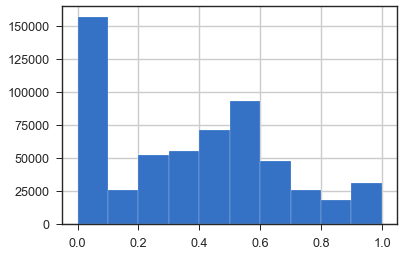

In [35]:
# look at the distribution
df.subjectivity_score.hist();

- We'll look more deeply at the relationship to sentiment in the next section.

# Step 4: Exploratory data analysis

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- First, we'll look for any trends in the distribution of sentiment between January 1 and May 31.

## Sentiment over time

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

### By day

In [36]:
# proportion of sentiments by day
df.groupby('date')['sentiment'].value_counts(normalize=True).unstack()

sentiment   negative   neutral  positive
date                                    
2020-01-01  0.692308  0.054945  0.252747
2020-01-02  0.566879  0.089172  0.343949
2020-01-03  0.602564  0.108974  0.288462
2020-01-04  0.587097  0.083871  0.329032
2020-01-05  0.500000  0.097701  0.402299
...              ...       ...       ...
2020-05-27  0.425400  0.180400  0.394200
2020-05-28  0.421400  0.177800  0.400800
2020-05-29  0.395200  0.148600  0.456200
2020-05-30  0.431400  0.148800  0.419800
2020-05-31  0.431200  0.141400  0.427400

[152 rows x 3 columns]

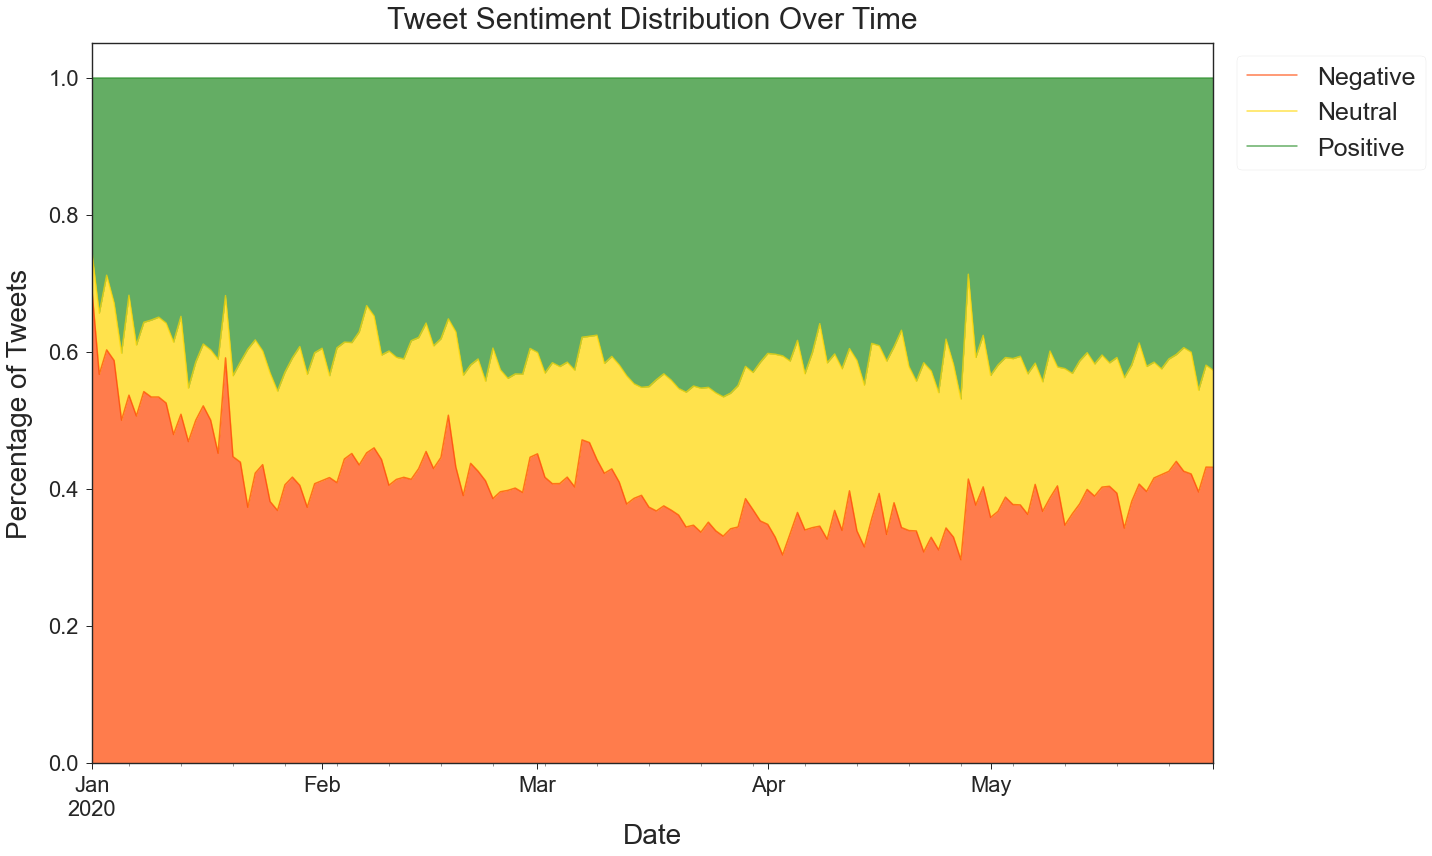

In [37]:
# proportion of sentiments by day
sent_by_day = df.groupby('date')['sentiment'].value_counts(normalize=True).unstack()

# plot a stacked line graph
p1 = sent_by_day.plot.area(stacked=True, figsize=(20,12),
                           color=['orangered', 'gold', 'forestgreen'], alpha=0.7)

# prettify the graph
p1.set_title('Tweet Sentiment Distribution Over Time', fontsize=30, pad=15)
p1.set_xlabel('Date', fontsize=28)
p1.set_ylabel('Percentage of Tweets', fontsize=28, labelpad=15)
p1.legend(['Negative', 'Neutral', 'Positive'], facecolor='white', framealpha=1,
          bbox_to_anchor=(1.01, 1.0), fontsize=25)
plt.setp(p1.get_xticklabels(), fontsize=22)
plt.setp(p1.get_yticklabels(), fontsize=22);

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/sentiment_stacked_line.png', bbox_inches='tight', transparent=True)

plt.show()

- Tweets start off as overwhelmingly *negative* in the first half of January, though it should be noted that there are far fewer tweets from that time period, so this should be taken with a rather large grain of salt.
- Mid-February is another point of interest, with a large spike in *negative* tweets, perhaps corresponding to the first rumblings of COVID in the US.
- Negativity appears to gradually decrease until the end of April, which corresponds with a spike in Topic 7 (Trump and the social distancing protests), and negativity increases until the end of May.
- Positivity has its strongest moments in mid- to late-March, but stays fairly constant throughout.
- Overall, we don't see any overwhelming shift in sentiment, merely a fairly consistently polarized twitterverse.

### Top tweets per day

- Let's see if the most popular tweets have a different distribution of sentiment over time.

In [38]:
# create dataframe of top twenty tweets per day by likes
top_20_by_day = []
for i in df.groupby('date')['nlikes'].nlargest(20).index:
    top_20_by_day.append(i[1])
    
top_20_by_day = df.loc[top_20_by_day]
top_20_by_day.shape

(3040, 21)

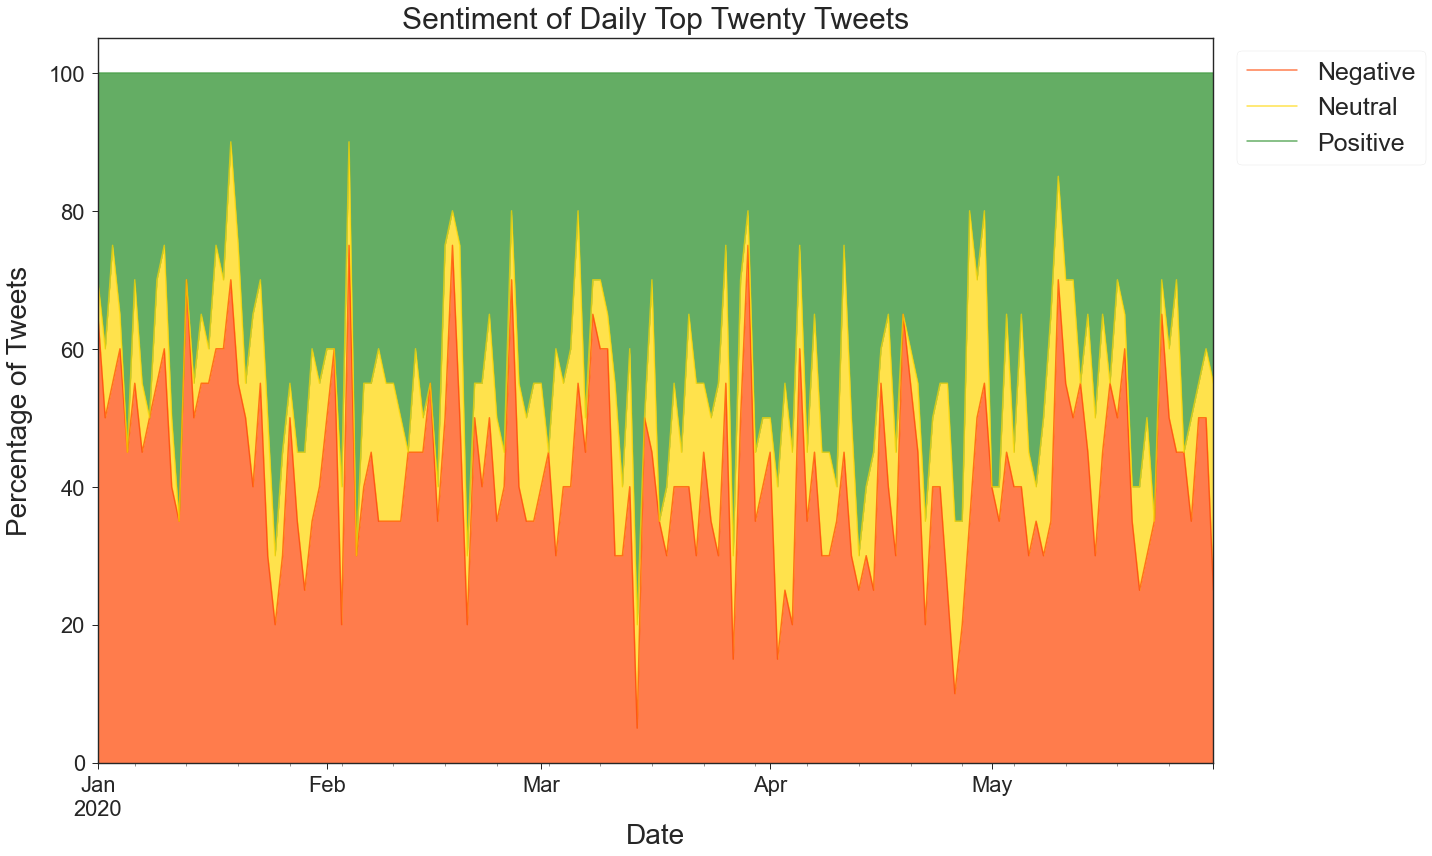

In [39]:
# proportion of sentiments of top twenty tweets by day
sent_top_20_by_day = top_20_by_day.groupby('date')['sentiment'].value_counts(normalize=True).unstack()

# plot a stacked line graph
p2 = sent_top_20_by_day.plot.area(stacked=True, figsize=(20,12),
                                   color=['orangered', 'gold', 'forestgreen'], alpha=0.7)

# prettify the chart
p2.set_title('Sentiment of Daily Top Twenty Tweets', fontsize=30, pad=10)
p2.set_xlabel('Date', fontsize=28)
p2.set_ylabel('Percentage of Tweets', fontsize=28, labelpad=15)
p2.set_yticklabels(range(0,101,20), fontsize=22)
plt.setp(p2.get_xticklabels(), fontsize=22)
p2.legend(['Negative', 'Neutral', 'Positive'], facecolor='white', framealpha=1,
          bbox_to_anchor=(1.01, 1.0), fontsize=25)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/sentiment_top20_stacked_line.png', bbox_inches='tight', transparent=True)

plt.show()

- No obvious trends here, just a lot of back and forth.
    - There is *maybe* a tendency toward *positive* sentiment toward the end, but both *positive* and *negative* again hover in the 40% range.
    
### By month

In [40]:
# create a month column
df['month'] = df.date.apply(lambda x: x.month)

# confirm
df['month'].head()

0    1
1    1
2    1
3    1
4    1
Name: month, dtype: int64

In [41]:
# look at the distribution of sentiment
df.groupby('month').sentiment.value_counts(normalize=True)

month  sentiment
1      positive     0.412410
       negative     0.409071
       neutral      0.178519
2      negative     0.421351
       positive     0.401875
       neutral      0.176774
3      positive     0.430681
       negative     0.387311
       neutral      0.182008
4      positive     0.405673
       negative     0.346020
       neutral      0.248307
5      positive     0.417239
       negative     0.393471
       neutral      0.189290
Name: sentiment, dtype: float64

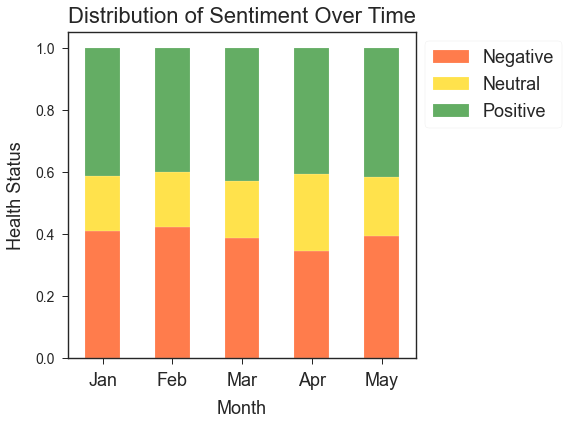

In [42]:
# prepare data for stacked bar
month_sentiment = df.groupby('month').sentiment.value_counts(normalize=True).unstack()

# plot stacked bar graph
p3 = month_sentiment.plot(kind='bar', stacked=True, figsize=(8,6),
                           color=['orangered', 'gold', 'forestgreen'], alpha=0.7, fontsize=14)

# prettify the graph
p3.set_title('Distribution of Sentiment Over Time', fontsize=22, pad=10)
p3.set_xlabel('Month', fontsize=18, labelpad=10)
p3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May'], rotation='horizontal', fontsize=18)
p3.set_ylabel('Health Status', fontsize=18, labelpad=10)
p3.legend(['Negative', 'Neutral', 'Positive'], fontsize=18, bbox_to_anchor=(1,1))

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/sentiment_month_barstack.png', bbox_inches='tight', transparent=True)

plt.show()

- *Positive* tweets gain a slight edge during March and April, but generally are fairly even.
- April stands out for having noticeably more *neutral* tweets, perhaps a result of wider news coverage.
- Let's see if this is statistically significant.

In [43]:
# create a frequency table
df_sent_month = pd.crosstab(df.sentiment, df.month)
df_sent_month

month          1      2      3      4      5
sentiment                                   
negative   16659  32905  58922  51903  60988
neutral     7270  13805  27689  37246  29340
positive   16795  31384  65520  60851  64672

In [44]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_sent_month)

# p-value shows significance
p

0.0

In [45]:
# create a table of standardized residuals; anything over +/- 1.96 shows significance
table = sm.stats.Table(df_sent_month)
table.standardized_resids

month              1          2          3          4          5
sentiment                                                       
negative   10.630207  22.851064   2.749761 -35.504190   8.616663
neutral   -11.381735 -17.652452 -20.757557  54.047020 -12.643540
positive   -1.249947  -8.220951  14.143637  -8.846112   1.762465

- With the exception of *positive* tweets in January and May, this is statistically significant.
- Let's turn month into dummy columns.

In [46]:
# dummy dataframe
month_dummies = pd.get_dummies(df.month, drop_first=True)

# reformat column names
month_dummies.columns = ['february', 'march', 'april', 'may']

# combine dataframe and dummy columns; drop columns
df = pd.concat([df, month_dummies], axis=1).drop(columns='month')

# confirm
df.head()

date  \
0 2020-01-01   
1 2020-01-01   
2 2020-01-01   
3 2020-01-01   
4 2020-01-01   

                                                                                                                                                   tweet  \
0                                               https://mltshp.com/p/1HLSB  "This is the death mask of Thomas, an unknown peasant that died in a river."   
1  Ready to heard this? Homemade hair treatment and ann cherry dead sea mud mask... Fucking putas swear they are more woman than me.... Bitch shut th...   
2  We all know what a joke #CCPChina is when it comes to epidemic outbreak,think of how they stayed silent about #SARS.\nDear world,stay away from #H...   
3                                                                                                            Thought death masks gave you the horn freak   
4                               Interesting cult of death mask he’s wearing, 🤔\nelectronically posing as he did as of the CIA while Brennan was Chief. 🧐   

         username  \
0  Best_of_MLTSHP   
1       lumora_lu   
2        odiecher   
3      Hevysmoker   
4        FaithR8s   

                                                            link  nlikes  \
0  https://twitter.com/Best_of_MLTSHP/status/1212523477896294400     1.0   
1       https://twitter.com/lumora_lu/status/1212518043353530368     0.0   
2        https://twitter.com/odiecher/status/1212517557690748928     1.0   
3      https://twitter.com/Hevysmoker/status/1212515585562726401     0.0   
4        https://twitter.com/FaithR8s/status/1212510409858670593     1.0   

   nreplies  nretweets sentiment  \
0       0.0        1.0  negative   
1       0.0        0.0  negative   
2       1.0        1.0  positive   
3       0.0        0.0  negative   
4       0.0        1.0  negative   

                                                                                                                                             clean_tweet  \
0                                                                                                                death thomas unknown peasant died river   
1                                                  ready heard homemade hair treatment ann cherry dead sea mud fucking putas swear woman bitch shut fuck   
2  joke #ccpchina come epidemic outbreakthink stayed silent #sars dear worldstay away #hk sure infected amongst already dear fellow #hkers facewithme...   
3                                                                                                                          thought death gave horn freak   
4                                                            interesting cult death thinkingface electronically posing cia brennan chief facewithmonocle   

   lda_topic_max  ...     lda_5     lda_6     lda_7     lda_8     lda_9  \
0              9  ...  0.020009  0.020008  0.219960  0.020008  0.619971   
1              0  ...  0.090425  0.000000  0.082588  0.000000  0.000000   
2              0  ...  0.067397  0.000000  0.067072  0.000000  0.000000   
3              0  ...  0.020007  0.020004  0.020005  0.219913  0.020018   
4              4  ...  0.014291  0.014295  0.014289  0.014289  0.241066   

   subjectivity_score  february  march  april  may  
0            0.600000         0      0      0    0  
1            0.560000         0      0      0    0  
2            0.462963         0      0      0    0  
3            0.000000         0      0      0    0  
4            0.500000         0      0      0    0  

[5 rows x 25 columns]

## Twitter statistics

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- First, let's look at the correlation between our Twitter statistics variables.

In [47]:
# columns to check
twit_stats = ['nlikes', 'nreplies', 'nretweets']

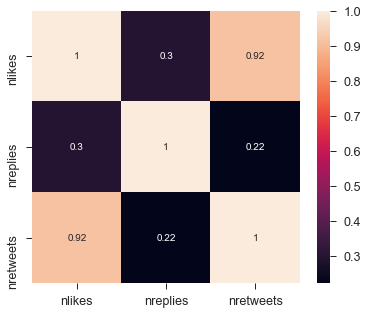

In [48]:
# plot correlation matrix
plt.figure(figsize=(6,5))
sns.heatmap(df[twit_stats].corr(), annot=True);

- Looks like ```nlikes``` and ```nretweets``` are very highly correlated, so we should drop one of those.
- We'll focus on number of likes and number of replies.

### Number of likes

- First, we'll see if the number of likes a tweet receives has any relationship to sentiment.

In [49]:
# descriptive stats
df.nlikes.describe()

count    575949.000000
mean         16.802193
std        1065.732148
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max      445739.000000
Name: nlikes, dtype: float64

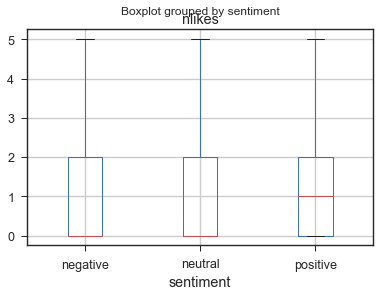

In [50]:
# distribution across sentiment
df.boxplot('nlikes', 'sentiment', showfliers=False);

In [51]:
# distribution across sentiment, tweets with at least 1 like
df[df.nlikes > 0].groupby('sentiment').tweet.count()

sentiment
negative    105461
neutral      49184
positive    121344
Name: tweet, dtype: int64

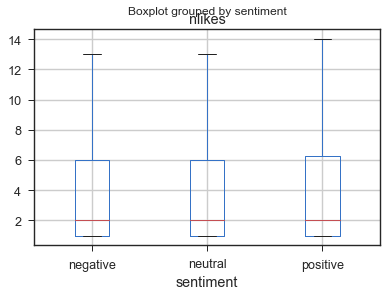

In [52]:
# distribution across sentiment, tweets with at least 1 like
df[df.nlikes > 0].boxplot('nlikes', 'sentiment', showfliers=False);

- Not much difference here, although it appears that *positive* tweets may garner more likes.
- Let's try converting to a categorical and doing some statistic tests.

In [53]:
# convert to categorical dummy based on whether a tweet received likes or not
df['likes'] = np.where(df.nlikes > 0, 1, 0)

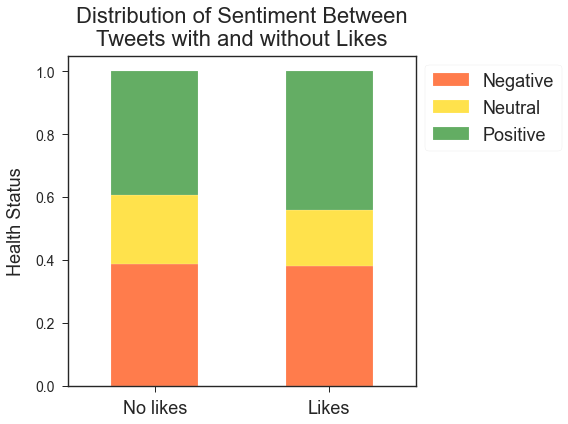

In [54]:
# prepare data for stacked bar
likes_sentiment = df.groupby('likes').sentiment.value_counts(normalize=True).unstack()

# plot stacked bar graph
p4 = likes_sentiment.plot(kind='bar', stacked=True, figsize=(8,6),
                           color=['orangered', 'gold', 'forestgreen'], alpha=0.7, fontsize=14)

# prettify the graph
p4.set_title('Distribution of Sentiment Between\nTweets with and without Likes', fontsize=22, pad=10)
p4.set_xlabel('')
p4.set_xticklabels(['No likes', 'Likes'], rotation='horizontal', fontsize=18)
p4.set_ylabel('Health Status', fontsize=18, labelpad=10)
p4.legend(['Negative', 'Neutral', 'Positive'], fontsize=18, bbox_to_anchor=(1,1))

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/sentiment_likes_barstack.png', bbox_inches='tight', transparent=True)

plt.show()

- This graph more clearly shows that *positive* tweets get likes at a higher rate and *neutral* tweets get likes at a lower rate, without much effect on *negative* tweets.
- Let's see if it's stastically significant.

In [55]:
# create a frequency table
df_sent_likes = pd.crosstab(df.sentiment, df.likes)
df_sent_likes

likes           0       1
sentiment                
negative   115916  105461
neutral     66166   49184
positive   117878  121344

In [56]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_sent_likes)

# p-value shows significance
p

0.0

In [57]:
# create a table of standardized residuals; anything over +/- 1.96 shows significance
table = sm.stats.Table(df_sent_likes)
table.standardized_resids

likes              0          1
sentiment                      
negative    3.365291  -3.365291
neutral    40.140785 -40.140785
positive  -35.921942  35.921942

- Number of likes is stastically significant! despite appearing fairly static in that first boxplot.
    - The p-value is incredibly low (near-zero).
    - All values of residuals are over +/- 1.96.

### Number of replies

- Let's run through the same process with the number of replies a tweet receives.

In [58]:
# descriptive stats
df.nreplies.describe()

count    575949.000000
mean          1.277884
std          45.999955
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max       24204.000000
Name: nreplies, dtype: float64

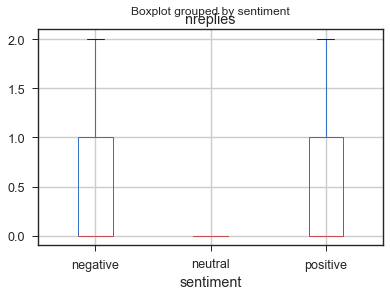

In [59]:
# distribution across sentiment
df.boxplot('nreplies', 'sentiment', showfliers=False);

In [60]:
# distribution across sentiment, tweets with at least 1 reply
df[df.nreplies > 0].groupby('sentiment').tweet.count()

sentiment
negative    64439
neutral     24900
positive    66934
Name: tweet, dtype: int64

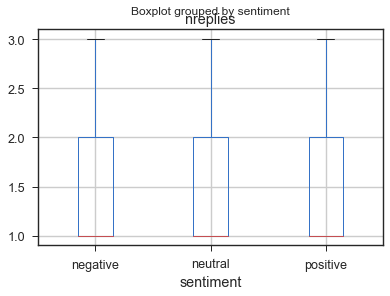

In [61]:
# distribution across sentiment, tweets with at least 1 reply
df[df.nreplies > 0].boxplot('nreplies', 'sentiment', showfliers=False);

In [62]:
# convert to categorical dummy based on whether a tweet received likes or not
df['replies'] = np.where(df.nreplies > 0, 1, 0)

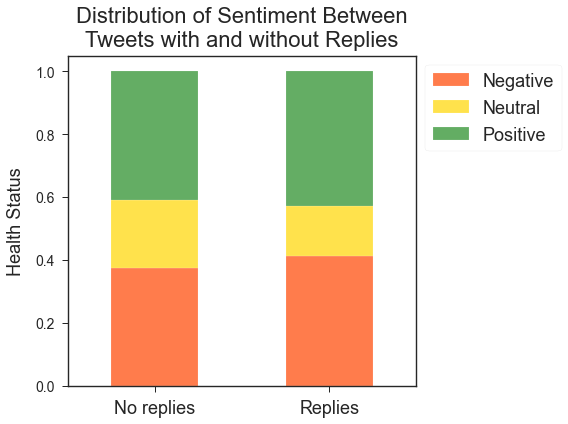

In [63]:
# prepare data for stacked bar
replies_sentiment = df.groupby('replies').sentiment.value_counts(normalize=True).unstack()

# plot stacked bar graph
p5 = replies_sentiment.plot(kind='bar', stacked=True, figsize=(8,6),
                           color=['orangered', 'gold', 'forestgreen'], alpha=0.7, fontsize=14)

# prettify the graph
p5.set_title('Distribution of Sentiment Between\nTweets with and without Replies', fontsize=22, pad=10)
p5.set_xlabel('')
p5.set_xticklabels(['No replies', 'Replies'], rotation='horizontal', fontsize=18)
p5.set_ylabel('Health Status', fontsize=18, labelpad=10)
p5.legend(['Negative', 'Neutral', 'Positive'], fontsize=18, bbox_to_anchor=(1,1))

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/sentiment_replies_barstack.png', bbox_inches='tight', transparent=True)

plt.show()

- Again, like the receiving likes, *neutral* tweets make up less of the tweets that receive replies.
- This time, however, *negative* tweets see the larger change in distribution when accounting for replies, although *positive* tweets do still show a slightly larger distribution as compared to tweets without replies.
- Let's see if it's stastically significant.

In [64]:
# create a frequency table
df_sent_replies = pd.crosstab(df.sentiment, df.replies)
df_sent_replies

replies         0      1
sentiment               
negative   156938  64439
neutral     90450  24900
positive   172288  66934

In [65]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_sent_replies)

# p-value shows significance
p

0.0

In [66]:
# create a table of standardized residuals; anything over +/- 1.96 shows significance
table = sm.stats.Table(df_sent_replies)
table.standardized_resids

replies            0          1
sentiment                      
negative  -26.637109  26.637109
neutral    47.375686 -47.375686
positive  -12.181110  12.181110

- Number of replies is stastically significant! again, like likes, despite appearing fairly static in that first boxplot.
    - The p-value is incredibly low (near-zero).
    - All values of residuals are over +/- 1.96 by a wide margin.
    
## Top words and vocabulary statistics

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- We'll next look at top words (after removing stop words and lemmatizing).
- Since we already processed the text, we can just turn all the tweets into one long strong and create a list of words by splitting on whitespace.

In [67]:
# make tweets into one big string
big_string = ' '.join(clean_tweets)

# confirm it worked
big_string[:100]

'death thomas unknown peasant died river ready heard homemade hair treatment ann cherry dead sea mud '

In [68]:
# split it into words
words = big_string.split()

###### Number of words in the corpus

In [69]:
# number of words after processing
len(words)

7596968

###### Total unique vocabulary

In [70]:
# unique word list
total_vocab = set(words)

# number of unique words
len(total_vocab)

242176

- Using a Counter dictionary, we can easily create a dictionary of words with their corresponding frequencies in the corpus. We can then look at the 25 most frequent words in our cleaned tweets.

In [71]:
Counter(words).most_common(25)

[('hand', 40134),
 ('need', 39384),
 ('spread', 33418),
 ('protect', 32088),
 ('make', 31605),
 ('help', 30306),
 ('say', 28477),
 ('glove', 27649),
 ('public', 25717),
 ('hospital', 25525),
 ('new', 25340),
 ('time', 25085),
 ('medical', 24652),
 ('china', 24641),
 ('doctor', 24152),
 ('home', 23986),
 ('work', 23382),
 ('day', 22567),
 ('stop', 21958),
 ('trump', 21074),
 ('infected', 21008),
 ('please', 20635),
 ('everyone', 20432),
 ('health', 20312),
 ('death', 20287)]

- Create a similar dictionary object using FreqDist and convert to DataFrame.

In [72]:
fdist = FreqDist(words)
fdist

FreqDist({'hand': 40134, 'need': 39384, 'spread': 33418, 'protect': 32088, 'make': 31605, 'help': 30306, 'say': 28477, 'glove': 27649, 'public': 25717, 'hospital': 25525, ...})

In [73]:
word_counts = pd.DataFrame(data=fdist.values(), index=fdist.keys(), columns=['word_count'])
word_counts = word_counts.sort_values('word_count', ascending=False)
word_counts.head()

word_count
hand          40134
need          39384
spread        33418
protect       32088
make          31605

- Take the top 25 words and create a visualization.

In [74]:
top25_words = word_counts.iloc[:25,:]

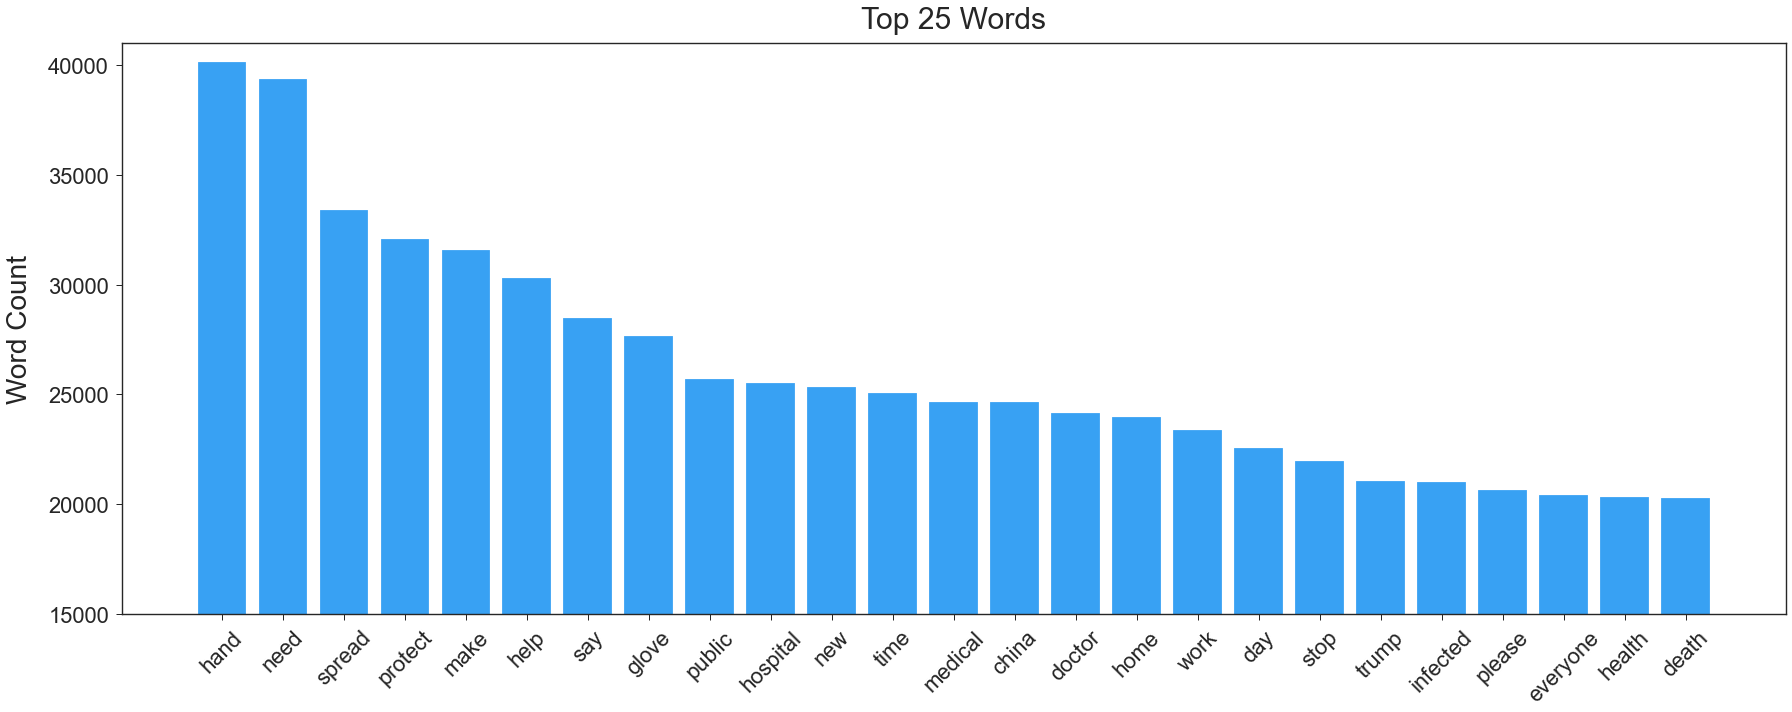

In [75]:
# prettify the chart
plt.figure(figsize=(25,10))
plt.title('Top 25 Words', fontsize=30, pad=15)
plt.ylabel('Word Count', fontsize=28, labelpad=15)
plt.xticks(rotation=45, fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(bottom=15000, top=41000)

# plot bar chart with twitter blue ;)
plt.bar(top25_words.index, top25_words.word_count, color='#38A1F3')

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/top25_words_bar.png', bbox_inches='tight', transparent=True)

plt.show()

### Most frequent words by sentiment

- Let's see if there are any notable differences between the most frequently used words across each sentiment.

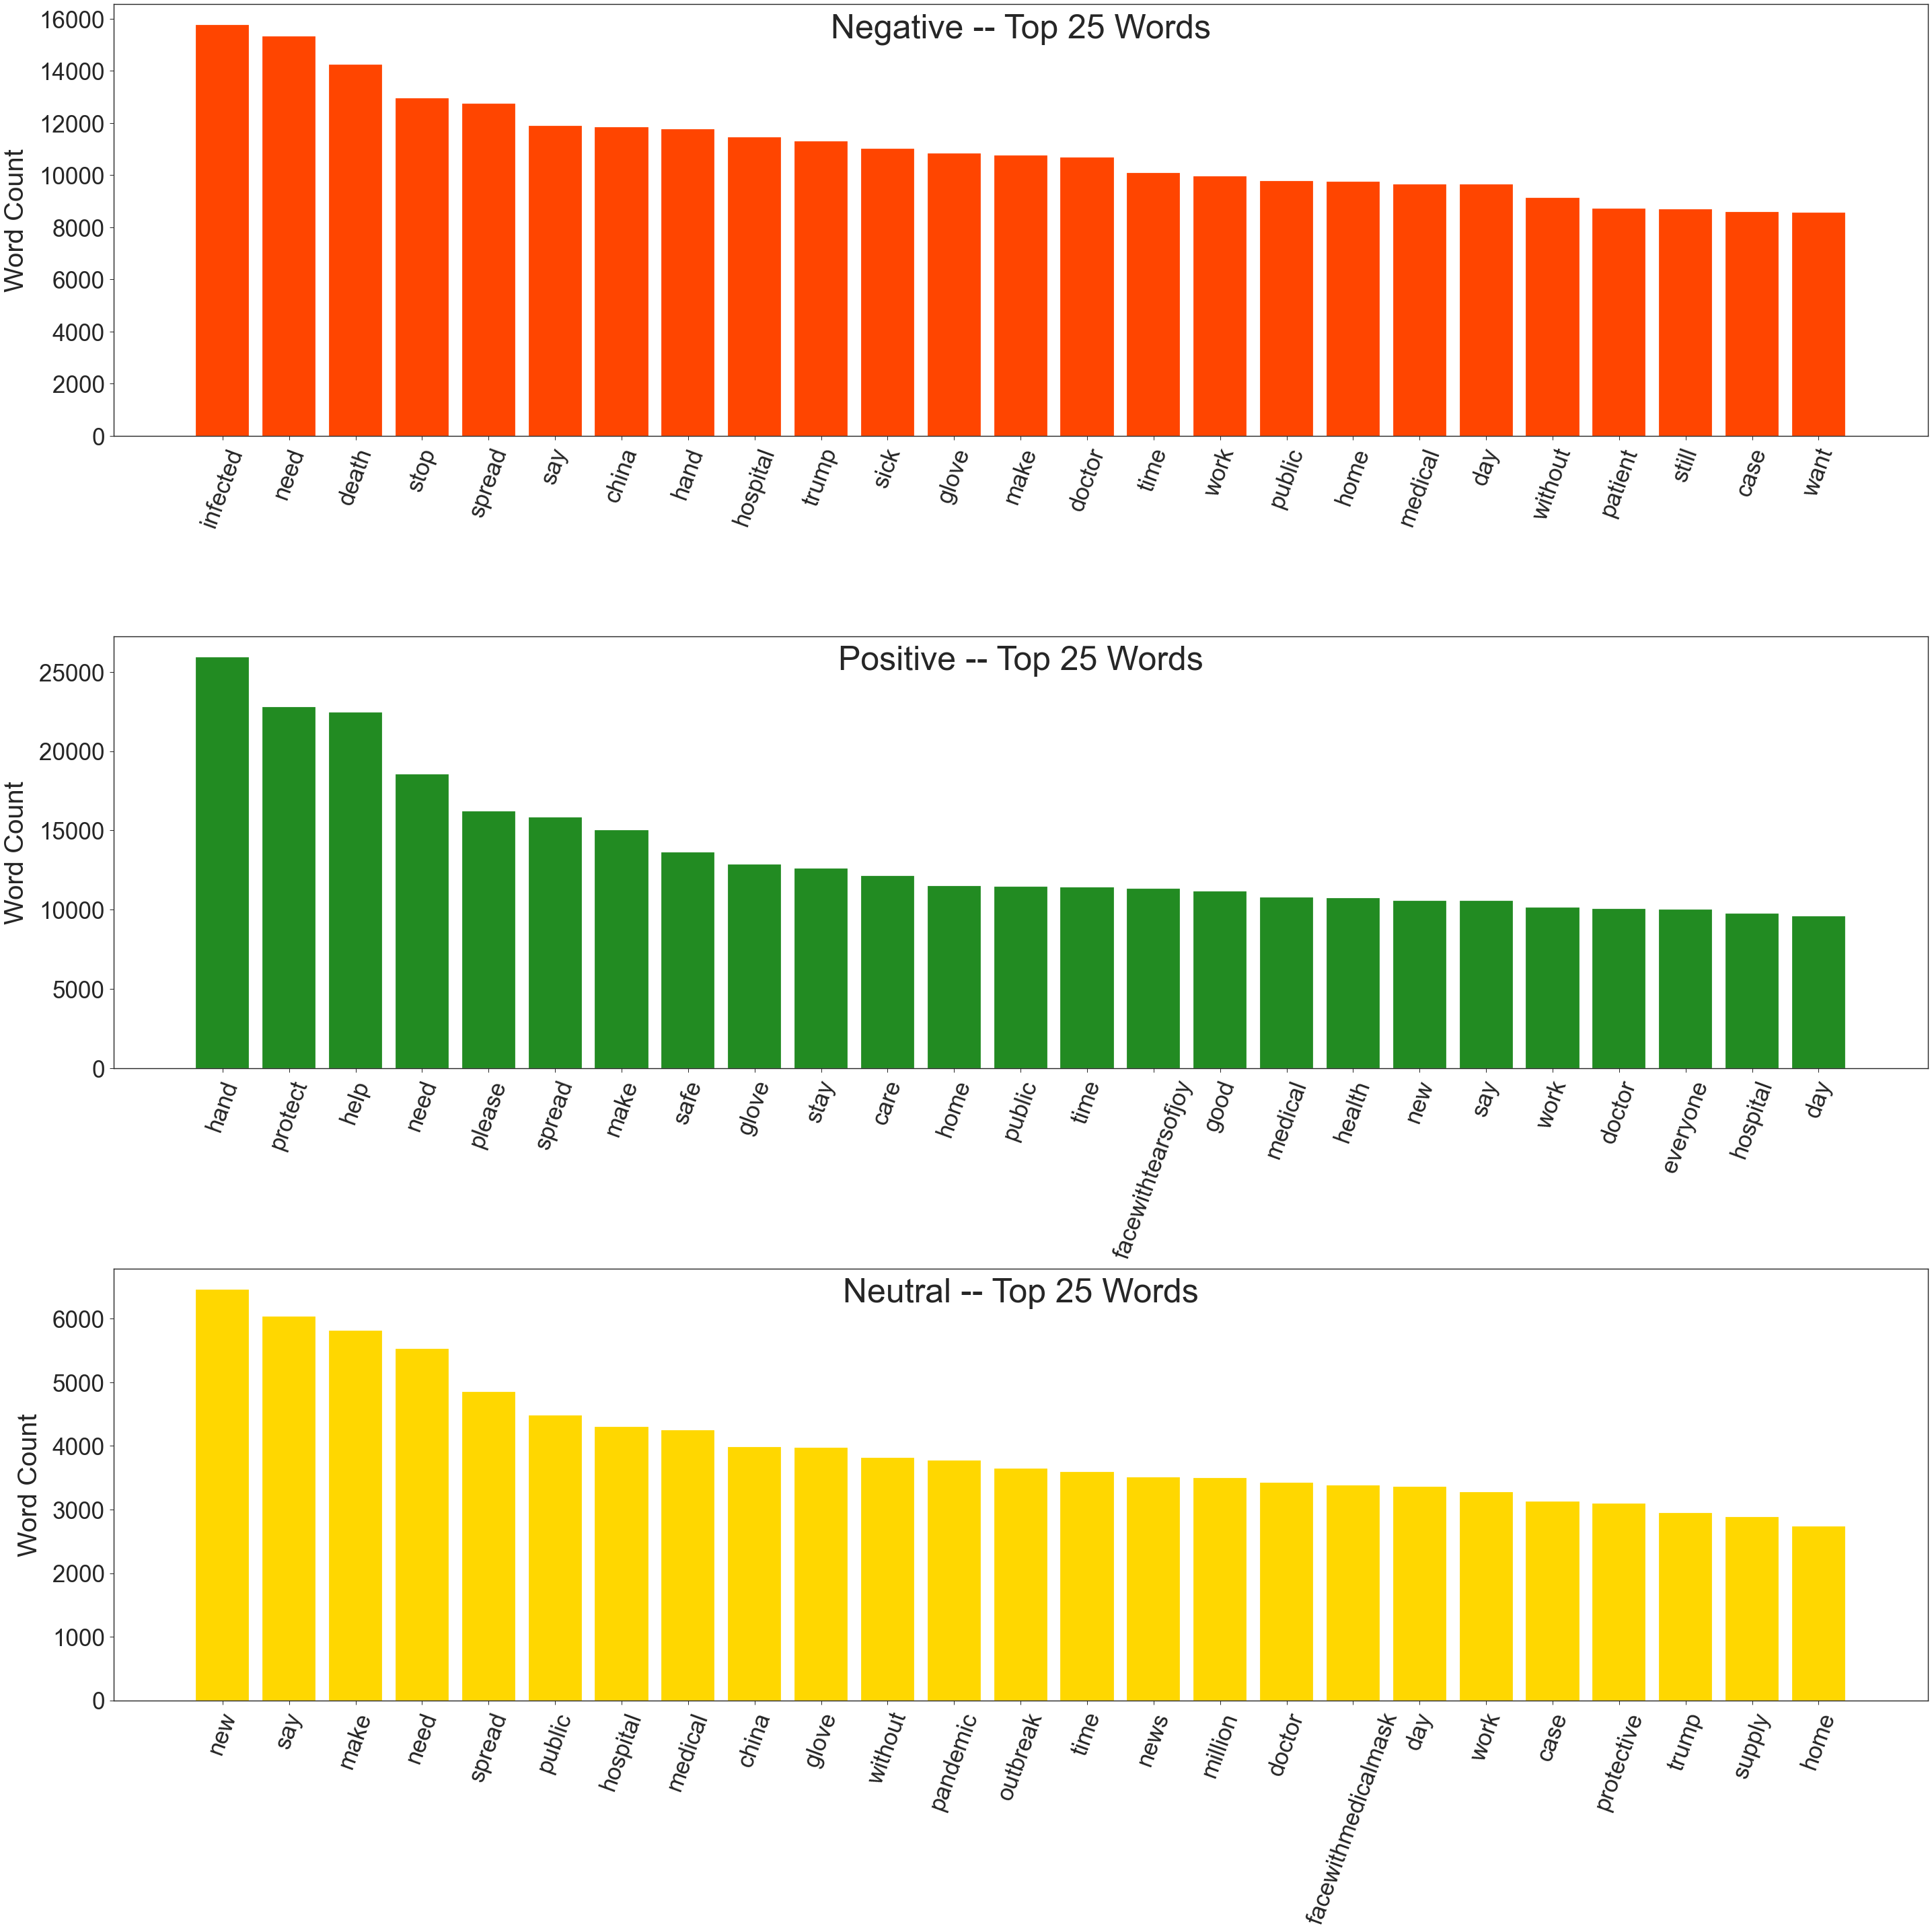

In [76]:
# instantiate a graph figure
plt.figure(figsize=(40,40))

# make a list of the sentiments
sentiments = list(df.sentiment.unique())

# loop over each sentiment
for i, sentiment in enumerate(sentiments):
    
    # create a series of processed tweets
    sentiment_string_series = df[df.sentiment == sentiment].clean_tweet
    
    # convert the series to one big string
    sentiment_big_string = ' '.join(sentiment_string_series)
    
    # split the big string so we get all words in the category
    sentiment_words = sentiment_big_string.split()
    
    # create dictionary of word counts
    fdist = FreqDist(sentiment_words)
    
    # convert word counts to dataframe
    fdist_df = pd.DataFrame(data=fdist.values(), index=fdist.keys(), columns=['word_count'])
    fdist_df = fdist_df.sort_values('word_count', ascending=False)
    
    # look at the top 25 words for the genre
    top_25 = fdist_df.iloc[:25,:]

    # set dimension of plots
    nrows = 3
    ncols = 1
    plt.subplot(nrows, ncols, i+1)

    # list of colors
    colors = ['orangered', 'forestgreen', 'gold']
    
    # prettify
    plt.title(f'{sentiment.title()} -- Top 25 Words', fontsize=50, pad=15, x=0.5, y=0.9)
    plt.ylabel('Word Count', fontsize=40, labelpad=15)
    plt.xticks(rotation=70, fontsize=35)
    plt.yticks(fontsize=35)
    
    # plot
    plt.bar(top_25.index, top_25.word_count, color=colors[i])
    plt.tight_layout()
    
# # uncomment to save
# plt.savefig('charts/top25_words_each_sentiment_bar.png', bbox_inches='tight', transparent=True)

- *Negative* tweets
    - A surprising number of medical terms, but also things like *death*, *Trump*, and *China*.
- *Positive* tweets
    - Also a lot of medical terms, but alongside terms of safety and protection and public good.
- *Neutral* tweets
    - Medical terms are higher up the list here and there are a lot of more "newsy" and statistical terms like *pandemic*, *outbreak*, *million*, *case*, *protective*, and *supply*.

### Word clouds

- Word clouds offer a more visually interesting option to present the same data.

In [77]:
# word cloud
word_dict = dict(Counter(words))
wordcloud = WordCloud(colormap='Spectral', width=1200, height=600).generate_from_frequencies(word_dict)

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# # uncomment to save
# plt.savefig('charts/word_cloud_all.png', bbox_inches='tight', transparent=True)

- We can also look at word clouds for each of the categories.**

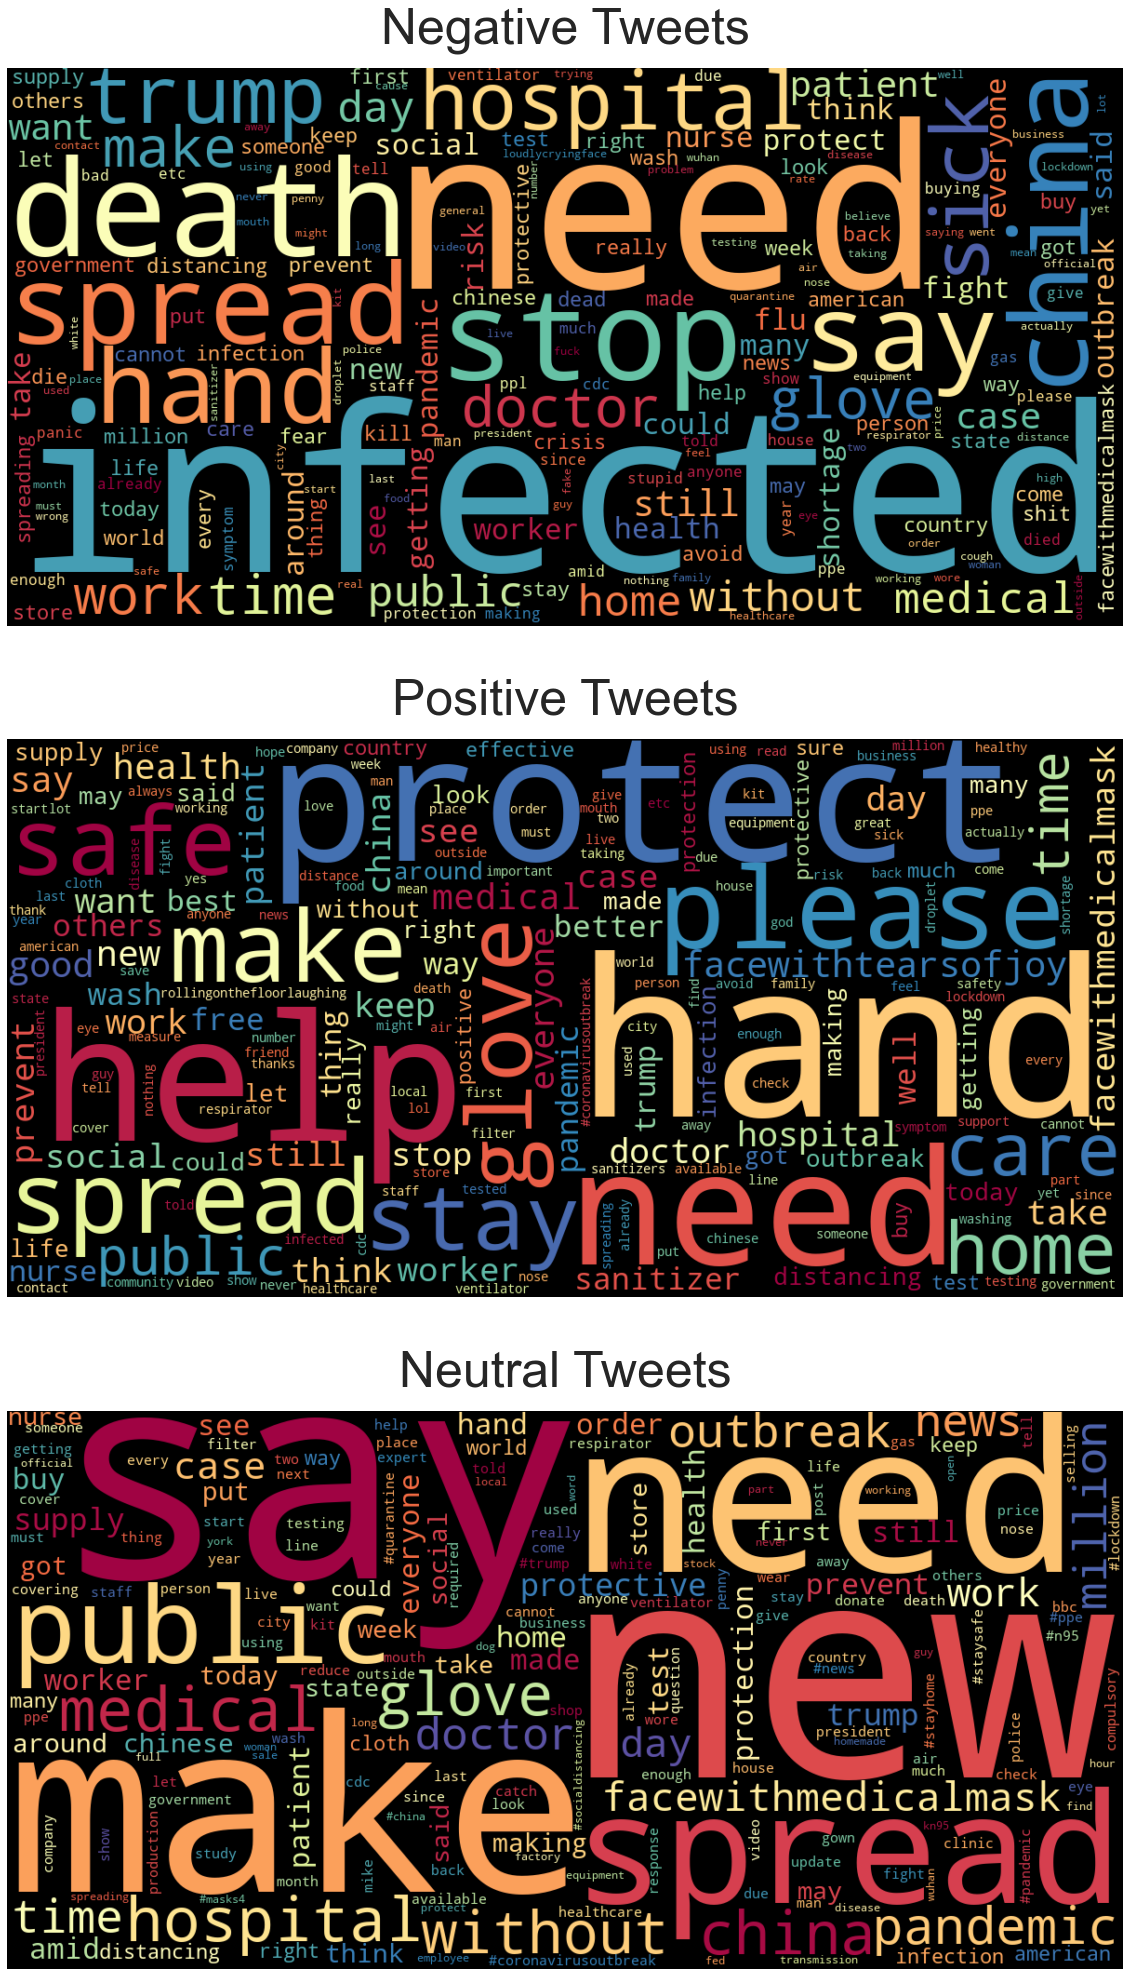

In [78]:
# instantiate a figure
plt.figure(figsize=(20,35))

# loop over sentiments list created earlier
for i, sentiment in enumerate(sentiments):
    
    # create a series of processed tweets
    sentiment_string_series = df[df.sentiment == sentiment].clean_tweet
    
    # convert the series to one big string
    sentiment_big_string = ' '.join(sentiment_string_series)
    
    # split the big string so we get all words in the category
    sentiment_words = sentiment_big_string.split()
    
    # create a dictionary for easy word cloud creation
    sentiment_word_dict = dict(Counter(sentiment_words))

    # create word cloud
    sentiment_wordcloud = WordCloud(colormap='Spectral', width=1200, height=600).\
                                                        generate_from_frequencies(sentiment_word_dict)

    # set dimension of plots
    nrows = 3
    ncols = 1

    # plot
    plt.subplot(nrows, ncols, i+1)
    plt.plot()
    plt.imshow(sentiment_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment.title()} Tweets', fontsize=50, pad=25)

# # uncomment to save
# plt.savefig('charts/word_cloud_each_sentiment.png', bbox_inches='tight', transparent=True)

- The urgency and sense of common good is especially apparent in the *positive* tweets here.

## LDA topics

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Look at how topics change across time.
- Look at the breakdown of sentiment per each topic.
- Look for any relationship between number of likes, replies, or retweets and topic.

### Topic distribution by day

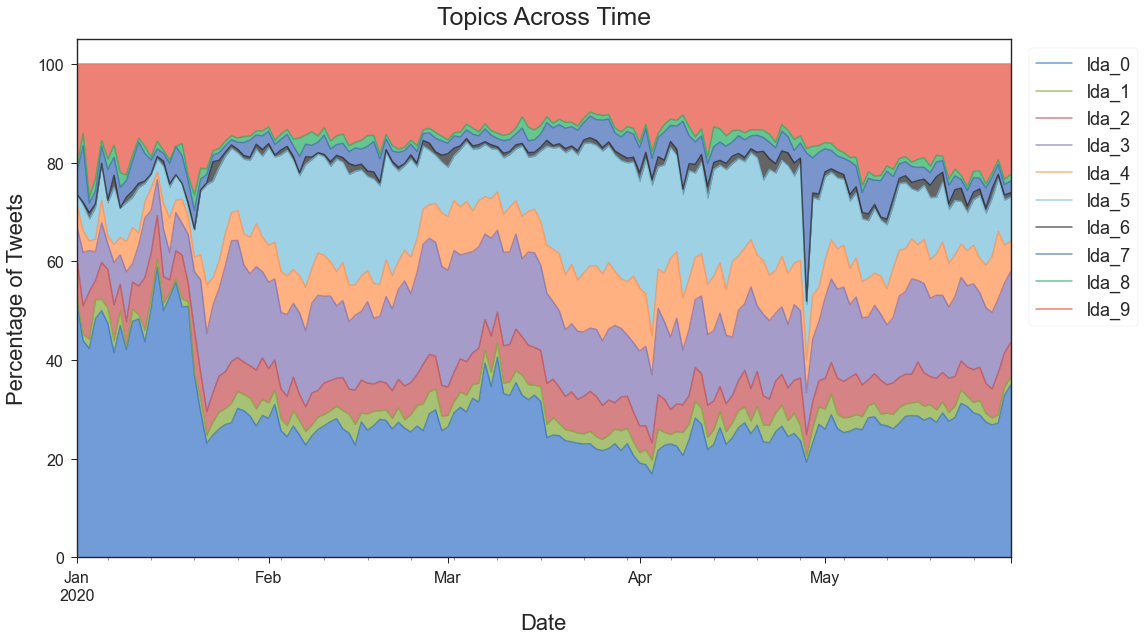

In [79]:
# sort by percentage of trees in good health
days = df.groupby('date').lda_topic_max.value_counts(normalize=True).unstack()

# plot a stacked bar graph
p6 = days.plot.area(stacked=True, figsize=(16,9), alpha=0.7, fontsize=16)

# prettify the graph
p6.set_title('Topics Across Time', fontsize=25, pad=15)
p6.set_xlabel('Date', fontsize=22, labelpad=10)
p6.set_ylabel('Percentage of Tweets', fontsize=22, labelpad=10)
p6.set_yticklabels(range(0,101,20), fontsize=16)
p6.legend([f'lda_{i}' for i in range(10)], facecolor='white',
          framealpha=1, bbox_to_anchor=(1.01, 1.0), fontsize=18)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/topics_across_time_barstack.png', bbox_inches='tight', transparent=True)

plt.show()

- Perhaps a bit too much going on in this graph, but it does show some interesting activity around January 20 and the end of April.

### Sentiment distribution by topic

- We'll now look at the relationship between sentiment and topics.

In [80]:
# sort by percentage of topics in good health
days = df.groupby('lda_topic_max').sentiment.value_counts(normalize=True).unstack()

# plot a stacked bar graph
p7 = days.plot(kind='bar', stacked=True, figsize=(12,7), color=['orangered', 'gold', 'forestgreen'],
               alpha=0.7, fontsize=16)

# prettify the chart
p7.set_title('Tweet Sentiment by Topic', fontsize=20, pad=10)
p7.set_xlabel('LDA Topic', fontsize=18, labelpad=10)
p7.set_ylabel('Percentage of Tweets', fontsize=18, labelpad=10)
p7.set_xticklabels(range(10), rotation=0, fontsize=16)
p7.set_yticklabels(range(0,101,20), fontsize=16)
p7.legend(['negative', 'neutral', 'positive'], facecolor='white', framealpha=1,
          bbox_to_anchor=(1.01, 1.0), fontsize=16)

# prepare to save and display
plt.tight_layout()
# # uncomment to save 
# plt.savefig('charts/sentiment_topics_barstack.png', bbox_inches='tight', transparent=True)

plt.show()

- Tweet topics have some definite affects on sentiment.
    - Topic 1 seems a bit strange to contain such a large amount of *neutral* tweets, something I assume mostly applies to news tweets, which makes sense for topic 6 (*news*, *study*, *claim*) and topic 8 (*data*, *nursing*).
        - Topic 1 has emojis, one of which is the generally ironic thinkingface and the other generally pro-mask.
        - Topic 8 does oddly contain *hoax* though this may be in relation to a news story reporting people's feelings toward COVID.
    - Topic 9 has a lot of *negative* tweets, which seems to make sense, discussing things like trump, death, social distancing (viewed negatively by some).
    - Topic 3 has the most *positive* tweets, which also seems to make sense, given words like *protect*, *help*, *others*, etc. It appears to be about the common good and using masks to help keep others safe.
    - Topic 7 interestingly has about equal numbers for all sentiment categories, and it does indeed seem to be the most polarizing of topics.
    - Topics 0 and 9 are relatively non-neutral.

In [81]:
# reference highly weighted words per topic
lda.print_topics()

[(0,
  '0.009*"protest" + 0.007*"facewithtearsofjoy" + 0.007*"think" + 0.007*"still" + 0.006*"want" + 0.006*"riot" + 0.006*"see" + 0.006*"got" + 0.005*"make" + 0.005*"without"'),
 (1,
  '0.013*"facewithmedicalmask" + 0.011*"county" + 0.011*"weekend" + 0.010*"design" + 0.010*"#health" + 0.010*"thinkingface" + 0.010*"shirt" + 0.009*"#sale" + 0.009*"period" + 0.009*"forgot"'),
 (2,
  '0.015*"business" + 0.011*"healthy" + 0.010*"#socialdistancing" + 0.009*"need" + 0.009*"taking" + 0.009*"biden" + 0.008*"care" + 0.008*"person" + 0.008*"u" + 0.007*"hide"'),
 (3,
  '0.014*"spread" + 0.013*"protect" + 0.011*"transmission" + 0.011*"distance" + 0.010*"safe" + 0.010*"cloth" + 0.010*"stay" + 0.010*"others" + 0.009*"prevent" + 0.008*"help"'),
 (4,
  '0.022*"pandemic" + 0.013*"fauci" + 0.012*"reduce" + 0.011*"wave" + 0.010*"guidance" + 0.010*"healthy" + 0.010*"#staysafe" + 0.009*"spread" + 0.009*"rule" + 0.008*"patient"'),
 (5,
  '0.013*"lockdown" + 0.009*"mandatory" + 0.009*"#pandemic" + 0.009*"wor

### Another look at sentiment distribution by topic

In [82]:
# instantiate a figure
plt.figure(figsize=(12,24))

# loop over sentiments list created earlier
for i, sentiment in enumerate(sentiments):
    
    sentiment_df = df[df.sentiment == sentiment]

    # set dimension of plots
    nrows = 3
    ncols = 1
    plt.subplot(nrows, ncols, i+1)

    # list of colors
    colors = ['orangered', 'forestgreen', 'gold']
    
    # prettify chart
    plt.title(f'Number of {sentiment.title()} Tweets by Topic', fontsize=28, pad=15)
    plt.xlabel('LDA Topic Number', fontsize=22, labelpad=15)
    plt.ylabel('Tweet Count', fontsize=24, labelpad=15)
    plt.xticks(range(10), rotation=0, fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(bottom=0, top=70000)
    
    # plot, making sure to sort the labels so they go in sequential order
    plt.bar(sentiment_df.lda_topic_max.value_counts().sort_index().index,
            sentiment_df.lda_topic_max.value_counts().sort_index(), 
            color=colors[i])
    plt.tight_layout(pad=5)
    
# # uncomment to save
# plt.savefig('charts/sentiment_topics_each_sentiment_barstack.png', bbox_inches='tight', transparent=True)

- This gives you a little more sense of how similarly sentiment is distributed across topics, with the shapes of these bars more or less the same across the three categories.
- Some notable exceptions:
    - Topic 5 has a large relative share of *neutral* tweets.
    - Topic 3 has a large relative share of *positive* tweets.
    - Topic 9 has a large relative share of *negative* tweets.
    - Topics 1, 6, and 7 are pretty evenly split amongst the three categories.
    
### LDA with numerical data

- We'll look at number of likes and replies across the topics.

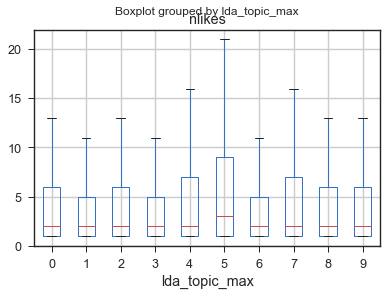

In [83]:
df[df.nlikes > 0].boxplot('nlikes', 'lda_topic_max', showfliers=False);

In [84]:
df[df.nreplies > 0].boxplot('nreplies', 'lda_topic_max', showfliers=False);

- No standout topics here.

## Subjectivity

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Look at the relationship between subjectivity and sentiment.
- Look at subjectivity across topics.

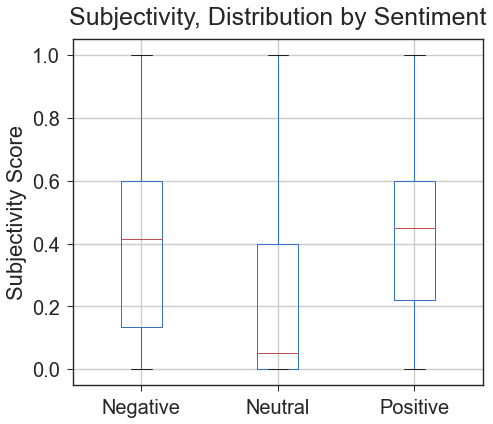

In [85]:
# plot the graph, subjectivity across sentiments
df.boxplot('subjectivity_score', 'sentiment', showfliers=False, figsize=(7,6))

# prettify the graph
plt.title('Subjectivity, Distribution by Sentiment', fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Subjectivity Score', fontsize=22, labelpad=5)
plt.xticks(ticks=range(1,4), labels=['Negative', 'Neutral', 'Positive'], fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/subjectivity_sentiment_box.png', bbox_inches='tight', transparent=True)

plt.show()

- As expected, *neutral* tweets tend to be more objective, whereas *positive* and *negative* tweets are more subjective.
- *Positive* and *negative* tweets have roughly the same distributions.

In [86]:
# plot the graph, subjectivity across topics
df.boxplot('subjectivity_score', 'lda_topic_max', showfliers=False, figsize=(12,6))

# prettify the graph
plt.title('Subjectivity, Distribution by Sentiment', fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Subjectivity Score', fontsize=22, labelpad=5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/subjectivity_lda_box.png', bbox_inches='tight', transparent=True)

plt.show()

- Some difference here but nothing too telling, given the generalness of LDA topics. But the graph shows a nice combination of the relationships between subjectivity and sentiment & LDA topics and sentiment.
- Let's save a couple versions of the dataset, one with everything we've created. And one with just the features we'll need in the next [notebook](04_modeling.ipynb).

In [87]:
df.columns

Index(['date', 'tweet', 'username', 'link', 'nlikes', 'nreplies', 'nretweets',
       'sentiment', 'clean_tweet', 'lda_topic_max', 'lda_0', 'lda_1', 'lda_2',
       'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9',
       'subjectivity_score', 'february', 'march', 'april', 'may', 'likes',
       'replies'],
      dtype='object')

#### 💾 Save/Load the DataFrame with all of the columns

In [88]:
# # uncomment to save
# with gzip.open('data/jan_thru_may_labeled_mask_tweets_all_features.pkl', 'wb') as goodbye:
#     pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

# # uncomment to load
# with gzip.open('data/jan_thru_may_labeled_mask_tweets_all_features.pkl', 'rb') as hello:
#     df = pickle.load(hello)

In [89]:
df_prepped = df[[
    'sentiment', 'clean_tweet', 'lda_0', 'lda_1', 'lda_2',
    'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9',
    'subjectivity_score', 'february', 'march', 'april', 'may',
    'replies', 'likes'
]]

#### 💾 Save/Load the DataFrame with necessary features

In [90]:
# # uncomment to save
# with gzip.open('data/jan_thru_may_labeled_mask_tweets_model_prepped.pkl', 'wb') as goodbye:
#     pickle.dump(df_prepped, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

# # uncomment to load
# with gzip.open('data/jan_thru_may_labeled_mask_tweets_model_prepped.pkl', 'rb') as hello:
#     df_prepped = pickle.load(hello)

## Next notebook: [Modeling](04_modeling.ipynb)

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- The next notebook includes classification modeling, a section with reproducible code for this project (including the work within this notebook), conclusions, and acknowledgements.